In [1]:


import sys
import os
import time
import pickle
from random import random,randrange
from scipy.integrate import odeint, ode, solve_ivp
from dataclasses import dataclass
import numpy as np
import torch
import matplotlib.pyplot as plt
import tikzplotlib
import torch.nn as nn
print( os.path.dirname( os.path.abspath('') ) )
sys.path.append( os.path.dirname( os.path.abspath('') ) )
from Functions.data_gen import (Interface_Dynamic_System, Factory_Dyn_Sys)
from Functions.nn_aprox_module import (Siren, Costum_NN, ODENet)
from Functions.library import LibraryObject, library_poly, _combinations, transform_torch
from Functions.data_set_preparation import DataSetFod, train_test_spliting_dataset
from torch.utils.data import DataLoader
from Functions.utiles import initial_cond_generation
from Functions.linear_coeffs_module import CoeffsNetwork, CoeffsDictionaryRational
######################
from Functions.root_classes_non_rational import CompleteNetwork
from Functions.training_non_rational import train
from Functions.model_recovery_func import model_recovery, model_recovery_single_noise_level
import Functions.plot_config_file

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(" We are using a "+ device + " for the simulation")

/home/forootani/Desktop/ineuralsindy2023/Code
 We are using a cuda for the simulation


In [2]:


@dataclass
class ParametersSetting:
    """
    Discription:
    a data class to set the input parameters
    
    Args:
        noise_level: A list of noise values can be given, e.g. [0, 0.02, 0.04]
                     The curves are plotted only for case of single noise value, e.g. [0.08] or [0.04]
                     If you increase the size of the noise level list, then modify the plotting section
        useRK: boolian, to activate RK4-SINDy method
        useNN: boolian, to activate iNeuralSINDy method 
                        to compare all the methods we should consider [True,True],[True,False], [False, True]
    """
    t_max = 10
    t_min = 0
    num_samples = 1500
    num_init_cond = 2
    num_indp_var = 2
    min_init_cond = 1
    max_init_cond = 4
    poly_order = 3
    fun_scaling_factor = 1
    max_iterations = 30000
    write_iterations = 5000
    threshold_iteration = 15000
    threshold_value = 0.05
    shuffle=False
    save_model_path: str = './Results/Cubic_Oscilator/'
    add_noise: bool = True
    noise_level = [0.25]
    useRK = [True, False]
    useNN = [True, False]
    tikz_save : bool = False
    name_pic_loss : str = 'Cubic_Oscilator_loss_noise_'
    name_pic_data : str = 'Cubic_Oscilator_training_data_noise_'
    name_pic_comparison : str = 'Cubic_Oscilator_noise_'




param_set = ParametersSetting()
ts = torch.linspace(param_set.t_min, param_set.t_max, param_set.num_samples)
os.makedirs(os.path.dirname(param_set.save_model_path), exist_ok=True)
RK_timestep = ts[1] - ts[0]


In [3]:


list_initial_conditions = initial_cond_generation(param_set.num_init_cond
                                                , param_set.num_indp_var
                                                , param_set.min_init_cond, param_set.max_init_cond)


list_initial_conditions = [[2, -2]]



coeff_noise_list = []
dic_coef_track_list = []
use_RK = [True, False]
use_NN = [True, False]


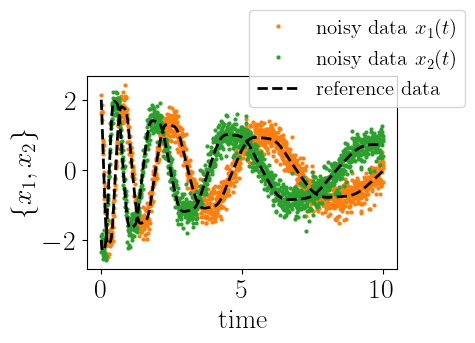

In [4]:
print("\n")



prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']


y = Factory_Dyn_Sys(ts,
                list_initial_conditions,
                 param_set.fun_scaling_factor,
                 "Cubic Damped Oscillator",
                  param_set.add_noise,
                  param_set.noise_level[0],)
(t_scaled_main, initial_cond_main,
                        u_original_main,
                        list_t_scaled_main, list_u_original, list_initial_cond_main, true_data_noise_free) = y.run()

y_2 = Factory_Dyn_Sys(ts,
                list_initial_conditions,
                 param_set.fun_scaling_factor,
                 "Cubic Damped Oscillator",
                  param_set.add_noise,
                  0,)
(t_scaled_main, initial_cond_main,
                        u_original_main_2,
                        list_t_scaled_main, list_u_original, list_initial_cond_main, true_data_noise_free) = y_2.run()



line_style = {'linestyle': "--"}

fig, axs = plt.subplots(1,1, figsize=(4, 2.5))


#plt.figure(1,figsize=(4, 2.5))
axs.plot(ts, u_original_main[:,0], "o", color = colors[1], markersize=2, label="noisy data $x_1(t)$ ")
axs.plot(ts, u_original_main[:,1], "o", color = colors[2], markersize=2, label= "noisy data $x_2(t)$ ")
axs.plot(ts, u_original_main_2[:,0], "k--", linewidth=2, label="reference data" )
axs.plot(ts, u_original_main_2[:,1], "k--", linewidth=2,)




lines, labels = [], []
for ax in fig.axes:
    line, label = ax.get_legend_handles_labels()
    lines.extend(line)
    labels.extend(label)

fig.legend(lines,labels, loc='center', bbox_to_anchor=(0.8, 0.95), ncol=1, bbox_transform=fig.transFigure, fontsize=15)    

axs.set(xlabel="time", ylabel="$\{x_1,x_2\}$")

#axs[0].xlabel('time', fontweight='bold',fontsize=20)
#plt.ylabel('$\{x_1(t),x_2(t)\}$', fontweight='bold',fontsize=20)

#plt.legend.Legend(loc='center', bbox_to_anchor=(0.5, 0.95), ncol=len(labels), bbox_transform=fig.transFigure, fontsize=25)    



plt.savefig(param_set.save_model_path + param_set.name_pic_comparison + str(param_set.noise_level[0]) +'_raw_data_'+ str(param_set.threshold_value)+'.pdf'
            ,bbox_inches='tight',dpi=300, transparent=True)

plt.savefig(param_set.save_model_path + param_set.name_pic_comparison + str(param_set.noise_level[0]) +'_raw_data_'+ str(param_set.threshold_value)+'.png',
            bbox_inches='tight',dpi=300, transparent=True)

#print(param_set.save_model_path)
#print(param_set.name_pic_comparison)






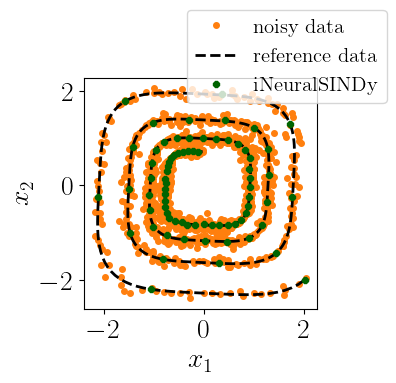

In [22]:



@dataclass
class ParametersSetting:
    """
    Discription:
    a data class to set the input parameters
    
    Args:
        noise_level: A list of noise values can be given, e.g. [0, 0.02, 0.04]
                     The curves are plotted only for case of single noise value, e.g. [0.08] or [0.04]
                     If you increase the size of the noise level list, then modify the plotting section
        useRK: boolian, to activate RK4-SINDy method
        useNN: boolian, to activate iNeuralSINDy method 
                        to compare all the methods we should consider [True,True],[True,False], [False, True]
    """
    t_max = 10
    t_min = 0
    num_samples = 2000
    num_init_cond = 2
    num_indp_var = 2
    min_init_cond = 1
    max_init_cond = 4
    poly_order = 3
    fun_scaling_factor = 1
    max_iterations = 30000
    write_iterations = 5000
    threshold_iteration = 15000
    threshold_value = 0.05
    shuffle=False
    save_model_path: str = './Results/Cubic_Oscilator/'
    add_noise: bool = True
    noise_level = [0.00]
    useRK = [True, False]
    useNN = [True, False]
    tikz_save : bool = False
    name_pic_loss : str = 'Cubic_Oscilator_loss_noise_'
    name_pic_data : str = 'Cubic_Oscilator_training_data_noise_'
    name_pic_comparison : str = 'Cubic_Oscilator_noise_'

param_set = ParametersSetting()

list_initial_conditions = [[2, -2]]

y_3 = Factory_Dyn_Sys(ts,
                list_initial_conditions,
                 param_set.fun_scaling_factor,
                 "Cubic Damped Oscillator",
                  param_set.add_noise,
                  0.00,)
(t_scaled_main, initial_cond_main,
                        u_original_main_3,
                        list_t_scaled_main, list_u_original, list_initial_cond_main, true_data_noise_free) = y_3.run()

y_4 = Factory_Dyn_Sys(ts,
                list_initial_conditions,
                 param_set.fun_scaling_factor,
                 "Cubic Damped Oscillator",
                  param_set.add_noise,
                  0.06,)
(t_scaled_main, initial_cond_main,
                        u_original_main_4,
                        list_t_scaled_main, list_u_original, list_initial_cond_main, true_data_noise_free) = y_4.run()



y_5 = Factory_Dyn_Sys(ts,
                list_initial_conditions,
                 param_set.fun_scaling_factor,
                 "Cubic Damped Oscillator",
                  param_set.add_noise,
                  0.01,)
(t_scaled_main, initial_cond_main,
                        u_original_main_5,
                        list_t_scaled_main, list_u_original, list_initial_cond_main, true_data_noise_free) = y_5.run()



line_style = {'linestyle': "--"}

fig, axs = plt.subplots(1,1, figsize=(3, 3))


#plt.figure(1,figsize=(4, 2.5))
axs.plot(u_original_main_4[:,0], u_original_main_4[:,1], "o", color = colors[1], markersize=4, label="noisy data ")
#axs.plot(ts, u_original_main[:,1], "o", color = colors[2], markersize=2, label= "noisy data $x_2(t)$ ")
axs.plot(u_original_main_3[:,0],u_original_main_3[:,1], "k--", linewidth=2, label="reference data" )
#axs.plot(ts, u_original_main_2[:,1], "k--", linewidth=2,)
axs.plot(u_original_main_5[:,0],u_original_main_5[:,1], color= 'darkgreen', linestyle = '', marker='8', markersize=4, markevery = 20, linewidth=2, label="iNeuralSINDy" )





lines, labels = [], []
for ax in fig.axes:
    line, label = ax.get_legend_handles_labels()
    lines.extend(line)
    labels.extend(label)
    

fig.legend(lines,labels, loc='center', bbox_to_anchor=(0.8, 0.95), ncol=1, bbox_transform=fig.transFigure, fontsize=15)    

axs.set(xlabel="$x_1$", ylabel="$x_2$")


plt.savefig(param_set.save_model_path + param_set.name_pic_comparison + str(param_set.noise_level[0]) +'_estimated_model_'+ str(param_set.threshold_value)+'.png',
            bbox_inches='tight',dpi=300, transparent=True)

